# DCGAN 실습

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다.
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Quiz

In [4]:
#quiz 1 (torch.permute)

sample_array = np.random.randn(2000, 64, 64, 3)
sample = torch.from_numpy(np.array(sample_array))

# sample => (2000, 64, 64, 3).  
# 위 sample 을 (2000, 3, 64, 64)로 바꿔보세요.
sample_1 = sample.permute(0, 3, 1, 2) # index 값을 넣어줘서 바꾼다.
print(sample_1.size())
#print(sample_1.size())
# H W C    <<   
# B C H W

torch.Size([2000, 3, 64, 64])


In [5]:
# 위 sample 을 (2000, 64, 3, 64)로 바꿔보세요.
sample_2 = sample.permute(0, 1, 3, 2 )
print(sample_2.size())

torch.Size([2000, 64, 3, 64])


In [6]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.permute(0,2,1)
print(a1.shape)
a2 = a.permute(1,2,0)
print(a2.shape)

torch.Size([5, 100, 20])
torch.Size([20, 100, 5])


In [7]:
#quiz 2 (torch.view)

sample = torch.from_numpy(np.array(sample_array))
print(sample.size())
sample_1 = sample.view(-1, 64*64*3)
# sample => (2000, 64, 64, 3).  
#위 sample 을 (2000, 64*64*3)으로 바꿔보세요.
print(sample_1.size())

sample_2 = sample.view(2000*64, -1)
#위 sample 을 (2000*64, 64*3)로 바꿔보세요.
print(sample_2.size())

torch.Size([2000, 64, 64, 3])
torch.Size([2000, 12288])
torch.Size([128000, 192])


In [8]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.view(2, 10, -1)
print(a1.shape)
a2 = a.view(-1,10, 200)
print(a2.shape)

torch.Size([2, 10, 500])
torch.Size([5, 10, 200])


## Convolution Layer

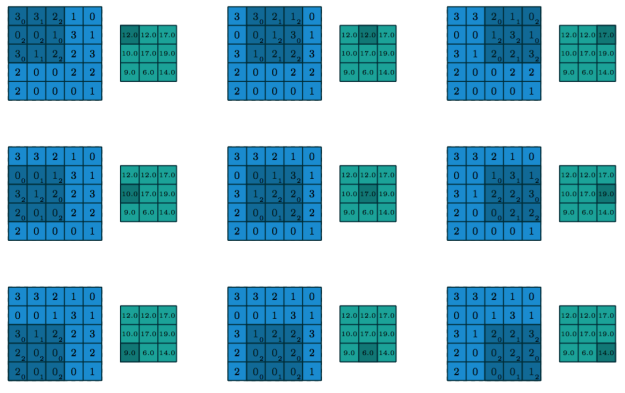

In [9]:
#quiz 3 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 512, 3, 1, 1)
conv2 = nn.Conv2d(512, 128, 5, 2, 2) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 128, 32, 32)

torch.Size([16, 128, 32, 32])


In [10]:
#quiz 4 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 64, 3, 1, 1)
conv2 = nn.Conv2d(64, 512, 7, 4, 2) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 512, 16, 16)

torch.Size([16, 512, 16, 16])


## Transpose Convolutional Layer

![Transpose Convolution](./imgs/1_Deconv.gif)

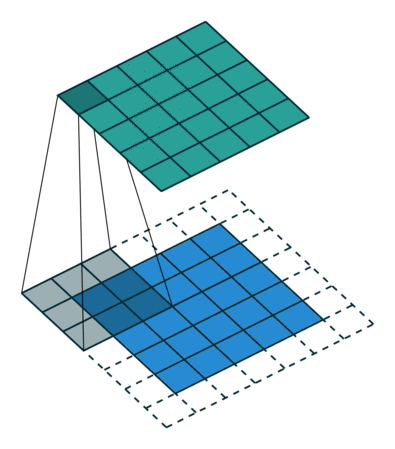

In [11]:
#quiz 5 (torch.nn.ConvTranspose2d)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, pad)
input1 = torch.zeros(16, 100, 1, 1)
conv1 = nn.ConvTranspose2d(100, 512, 4, 2, 1)
conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1) # quiz

out = conv1(input1)
print(out.size())
out = conv2(out)
print(out.size())
# print(out.size()) = (16, 256, 4, 4)

torch.Size([16, 512, 2, 2])
torch.Size([16, 256, 4, 4])


# CIFAR10 DCGAN
## Data Loader 불러오기

In [12]:
def CIFAR10_DATA(root='/content/drive/MyDrive/12-28실습자료/data', download =True, batch_size=64, num_worker=1):
    print ("[+] Get the CIFAR-10 DATA")
    """
    torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다.
    """
    transform = T.Compose([T.ToTensor(), # 얻어낸 데이터를 pytorch가 계산 할 수 있는 Tensor 로 변환해 줍니다. 
                           T.Normalize(mean=(0.5, 0.5, 0.5), 
                                       std=(0.5, 0.5, 0.5))]) # 0 ~ 1 사이 데이터 정규화 할때 0.5, 더 나은 학습을 위해 다른 값을 넣을 수도 있다.
    
    cifar10_train = datasets.CIFAR10(root = root,  #root 는 데이터의 저장 위치 입니다. 
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
    cifar10_test = datasets.CIFAR10(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
                                transform = transform,
                                download = True)
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    * Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
    커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
    """
    trainDataLoader = data.DataLoader(dataset = cifar10_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = cifar10_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return cifar10_train, cifar10_test, trainDataLoader, testDataLoader

In [13]:
trainDset, testDset, trainDataLoader, testDataLoader = CIFAR10_DATA(batch_size=64, num_worker=4)  # Data Loader 를 불러 옵니다. 

[+] Get the CIFAR-10 DATA
Files already downloaded and verified
Files already downloaded and verified
[+] Finished loading data & Preprocessing


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## CIFAR10 Data 확인

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


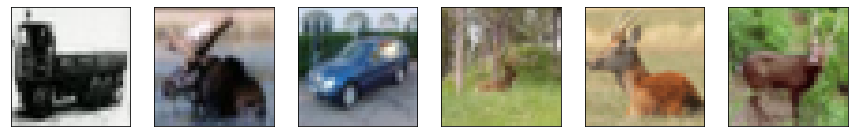

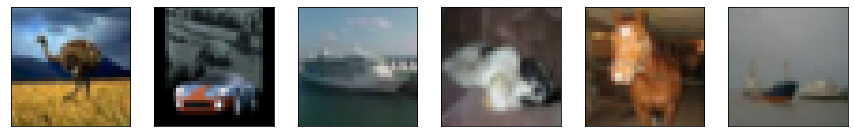

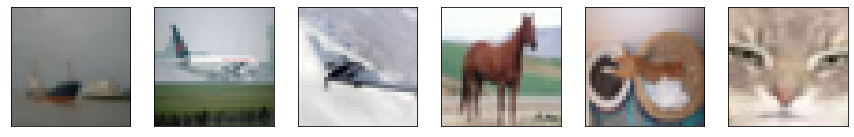

In [14]:
def show_images(image, n_row):
    for _ in range(n_row):  
        index=np.random.choice(64, 6)
        images =image.numpy()[index]
        plt.figure(figsize=(15,90))    
        for a in range(161, 167):    
            plt.subplot(a)
            plt.imshow(images[(a-161)].transpose(1,2,0))
            plt.xticks([])
            plt.yticks([])    
        plt.show()  

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
        
for i, (image,_) in enumerate(trainDataLoader):
    show_images(denorm(image.squeeze()), 3)
    break

## Generator, Discriminator

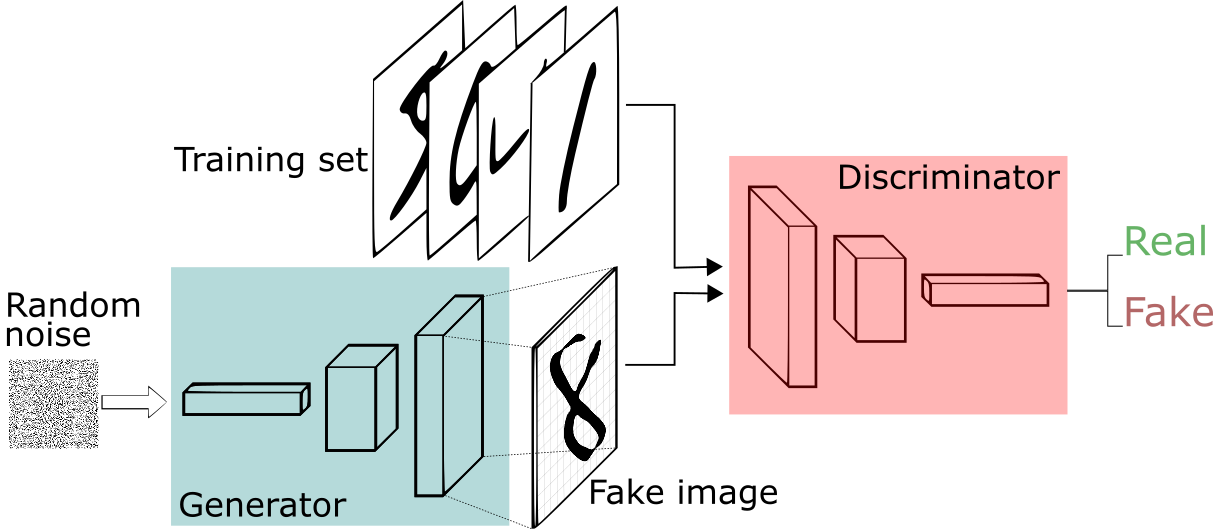

# DCGAN

In [15]:
'''
코드 단순화를 위한 함수들을 정의해 줍니다.
'''

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 convolution block 생성을 위한 함수입니다.
    Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    layers = []
    
    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
                
    return nn.Sequential(*layers)
  
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 deconvolution block 생성을 위한 함수입니다.
    Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
                
    return nn.Sequential(*layers)

In [16]:
class Generator(nn.Module):
    """Generator"""
    def __init__(self, z_dim=256, image_size=32, conv_dim=64):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*4, int(image_size/8), 1, 0, bn=False) # (B, 256, 4, 4)
        self.deconv1 = deconv(256, 128, 4, activation='relu') # (B, 128, 8, 8)
        self.deconv2 = deconv(128, 64, 4, activation='relu') # (B, 64, 16, 16)
        self.deconv3 = deconv(64, 3, 4, bn=False, activation='tanh') # (B, 3, 32, 32)
        
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = self.fc(z)                            
        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        return out

In [17]:
g = Generator()
z = torch.randn(16, 256)
out = g(z)
print(out.shape)

torch.Size([16, 3, 32, 32])


In [18]:
class Discriminator(nn.Module):
    """Discriminator"""
    def __init__(self, image_size=32, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, 64, 4, bn=False, activation='lrelu')# (B, 64, 16, 16) input이 rgb 이면 "3"으로 받는다.
        self.conv2 = conv(64, 128, 4, activation='lrelu')# (B, 128, 8, 8)
        self.conv3 = conv(128, 256, 4, activation='lrelu')# (B, 256, 4, 4)
        self.fc = conv(conv_dim*4, 1, int(image_size/8), 1, 0, False)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = torch.sigmoid(self.fc(out).squeeze()) # Sigmoid 함수를 사용해야 합니다.
        return out

In [19]:
# build model
G = Generator(z_dim=256, image_size=32, conv_dim=64).cuda()
D = Discriminator(image_size=32, conv_dim=64).cuda()

In [20]:
img = torch.randn(16, 3, 32, 32).cuda()
print(img)

tensor([[[[ 2.7678e-01, -4.2430e-01, -2.7188e+00,  ..., -1.0779e-01,
           -5.9775e-01, -3.6246e-01],
          [ 2.4367e+00,  5.1475e-01,  6.9677e-02,  ...,  4.3219e-01,
            4.4004e-01,  1.1358e+00],
          [ 1.7817e+00, -1.5248e+00, -1.5395e-01,  ...,  4.9119e-01,
           -2.8470e-01, -9.6835e-01],
          ...,
          [-4.2384e-01,  1.0111e+00, -1.4153e+00,  ..., -5.6572e-01,
           -2.8627e-01, -1.8506e-01],
          [-1.2181e+00, -6.0596e-01, -6.8631e-01,  ..., -3.5835e-01,
           -1.0469e+00, -1.0575e-01],
          [ 1.4324e+00, -2.8294e-01,  1.1949e+00,  ...,  1.4351e+00,
           -4.9143e-01, -6.8399e-01]],

         [[ 9.6542e-01,  1.3010e-01, -5.0622e-01,  ..., -1.7846e-01,
            7.9051e-01, -1.1610e+00],
          [ 2.9275e+00,  3.7476e-01,  4.5410e-02,  ..., -1.4842e+00,
           -2.5252e+00,  9.7012e-02],
          [-6.2823e-01, -4.6433e-01,  8.5567e-01,  ..., -6.4119e-02,
           -8.9546e-01,  4.4596e-01],
          ...,
     

## Train DCGAN

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0/20], Step[300/782], d_loss: 0.8385, g_loss: 1.4933


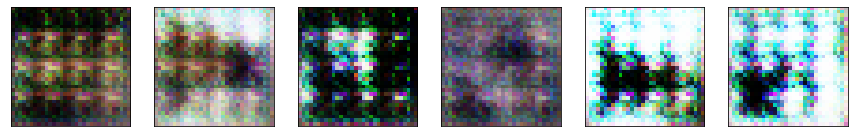

Epoch [0/20], Step[600/782], d_loss: 0.6102, g_loss: 1.6032


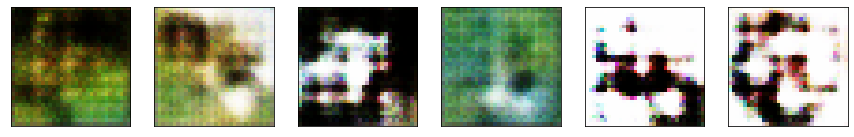

Epoch [1/20], Step[300/782], d_loss: 0.7650, g_loss: 1.2084


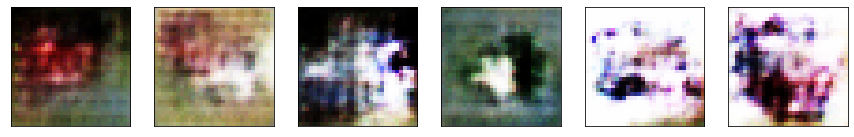

Epoch [1/20], Step[600/782], d_loss: 0.5462, g_loss: 1.0053


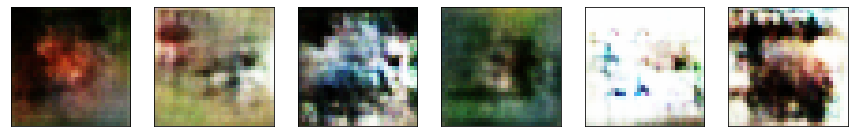

Epoch [2/20], Step[300/782], d_loss: 0.7498, g_loss: 1.3967


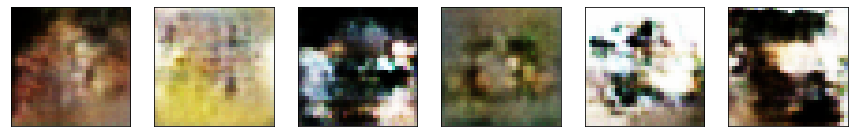

Epoch [2/20], Step[600/782], d_loss: 0.5401, g_loss: 1.2436


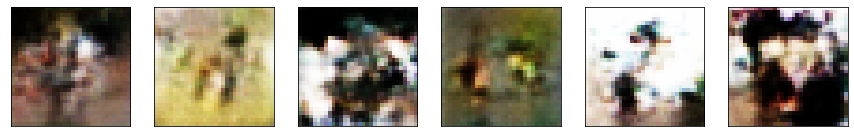

Epoch [3/20], Step[300/782], d_loss: 0.8188, g_loss: 0.8695


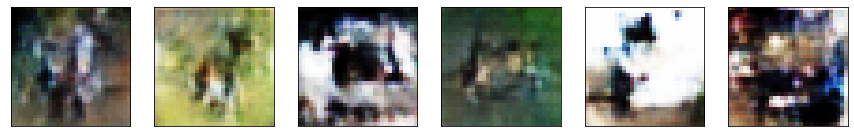

Epoch [3/20], Step[600/782], d_loss: 0.7500, g_loss: 1.4057


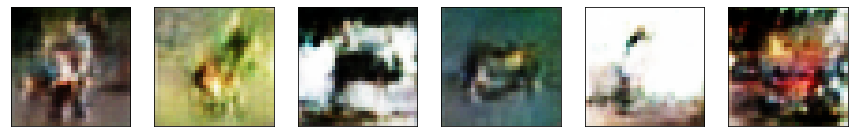

Epoch [4/20], Step[300/782], d_loss: 0.5858, g_loss: 1.0915


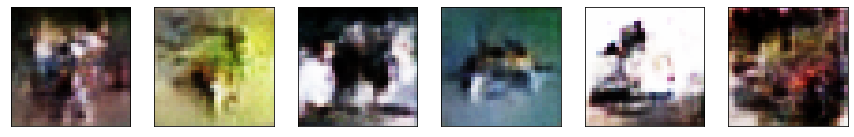

Epoch [4/20], Step[600/782], d_loss: 0.6892, g_loss: 0.9998


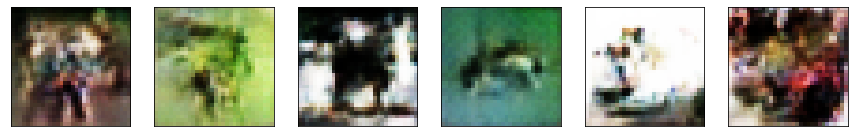

Epoch [5/20], Step[300/782], d_loss: 0.6522, g_loss: 1.2369


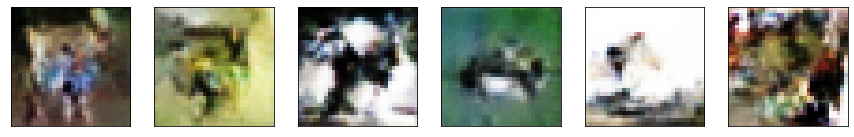

Epoch [5/20], Step[600/782], d_loss: 0.6442, g_loss: 1.0796


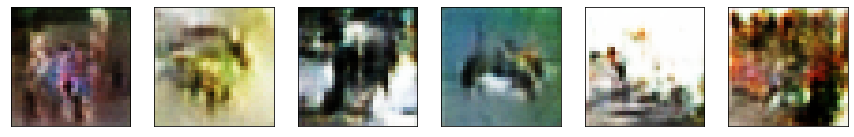

Epoch [6/20], Step[300/782], d_loss: 0.8280, g_loss: 1.1183


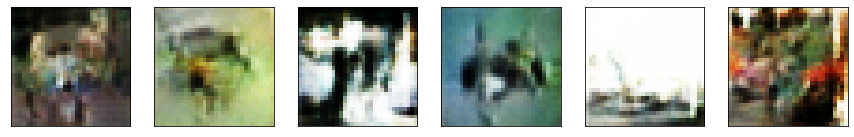

Epoch [6/20], Step[600/782], d_loss: 0.5275, g_loss: 1.1083


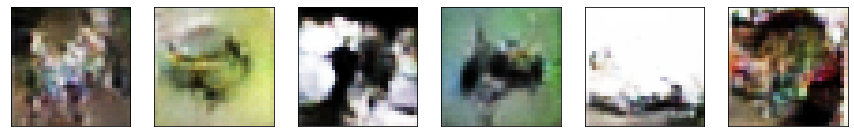

Epoch [7/20], Step[300/782], d_loss: 0.6453, g_loss: 1.4141


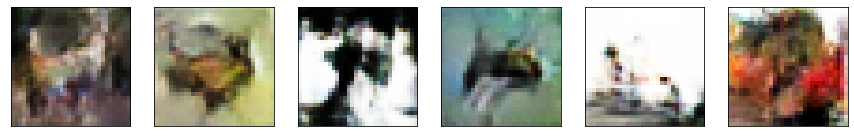

Epoch [7/20], Step[600/782], d_loss: 1.5035, g_loss: 2.3781


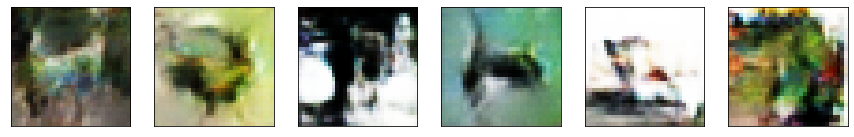

Epoch [8/20], Step[300/782], d_loss: 0.6801, g_loss: 1.4973


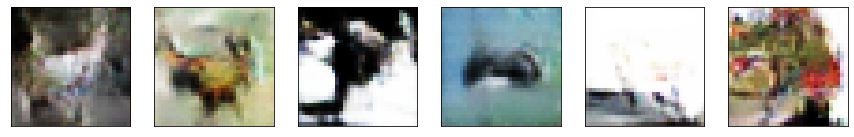

Epoch [8/20], Step[600/782], d_loss: 0.5449, g_loss: 1.1620


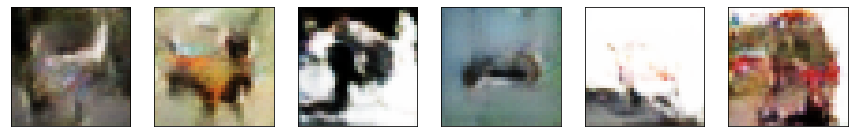

Epoch [9/20], Step[300/782], d_loss: 0.8063, g_loss: 1.1916


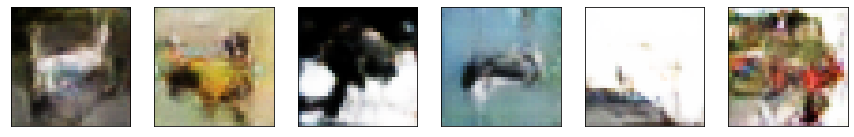

Epoch [9/20], Step[600/782], d_loss: 0.5573, g_loss: 0.9591


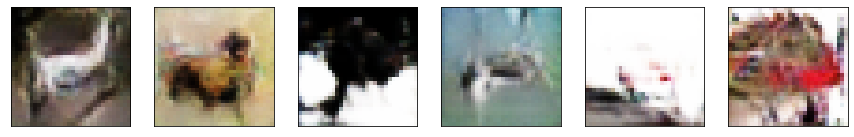

Epoch [10/20], Step[300/782], d_loss: 0.6088, g_loss: 1.4223


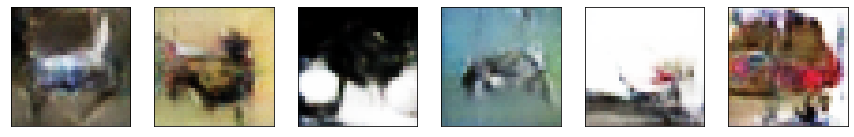

Epoch [10/20], Step[600/782], d_loss: 0.5142, g_loss: 1.2577


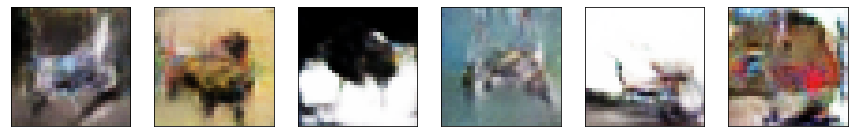

Epoch [11/20], Step[300/782], d_loss: 0.6110, g_loss: 1.3768


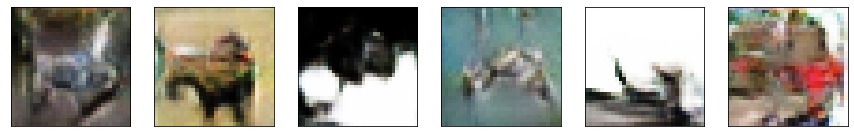

Epoch [11/20], Step[600/782], d_loss: 0.5685, g_loss: 1.0841


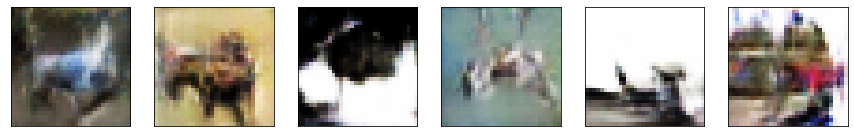

Epoch [12/20], Step[300/782], d_loss: 0.5430, g_loss: 1.0939


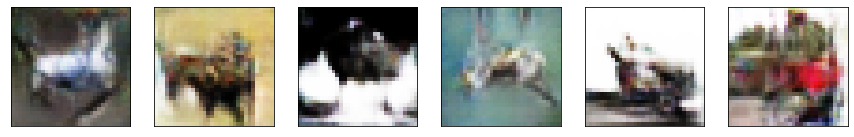

Epoch [12/20], Step[600/782], d_loss: 0.4712, g_loss: 0.9424


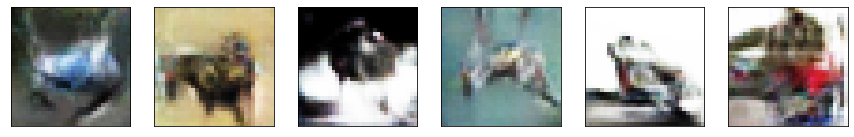

Epoch [13/20], Step[300/782], d_loss: 0.5486, g_loss: 1.0946


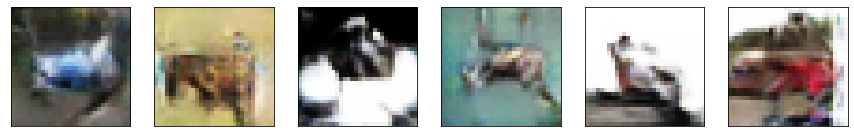

Epoch [13/20], Step[600/782], d_loss: 0.7097, g_loss: 1.7976


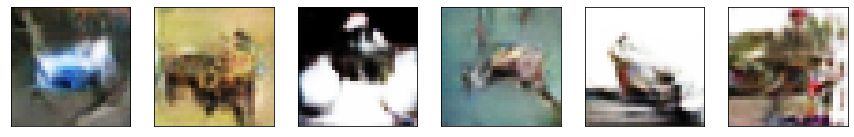

Epoch [14/20], Step[300/782], d_loss: 0.8359, g_loss: 1.0933


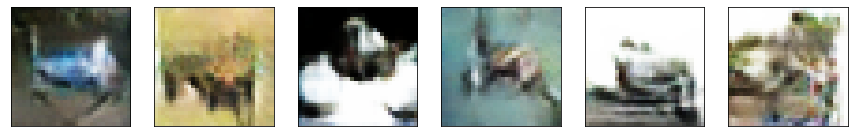

Epoch [14/20], Step[600/782], d_loss: 0.5640, g_loss: 1.5952


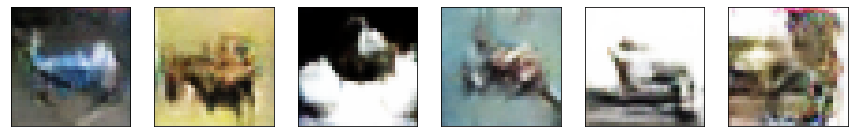

Epoch [15/20], Step[300/782], d_loss: 0.4300, g_loss: 1.0304


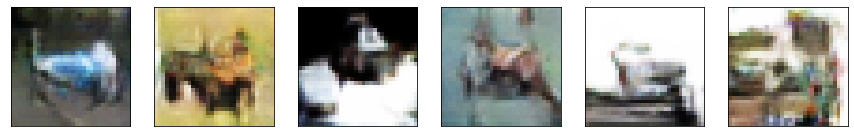

Epoch [15/20], Step[600/782], d_loss: 0.8821, g_loss: 2.2576


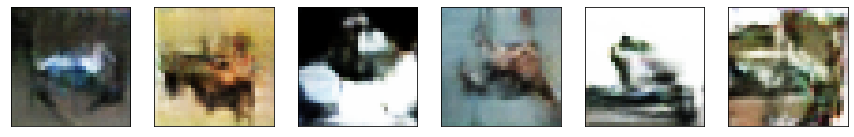

Epoch [16/20], Step[300/782], d_loss: 0.4703, g_loss: 1.3062


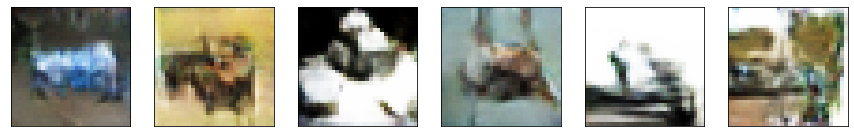

Epoch [16/20], Step[600/782], d_loss: 0.5205, g_loss: 1.2571


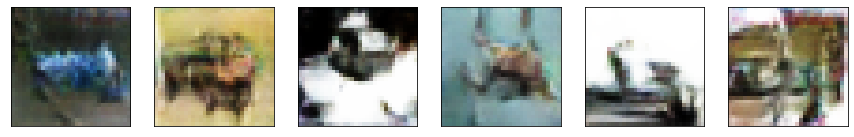

Epoch [17/20], Step[300/782], d_loss: 0.7428, g_loss: 1.2963


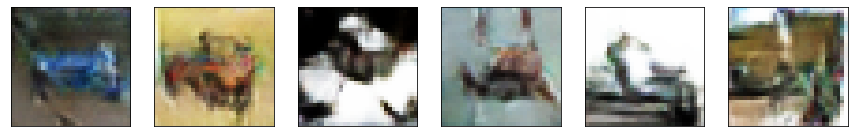

Epoch [17/20], Step[600/782], d_loss: 0.9898, g_loss: 2.4150


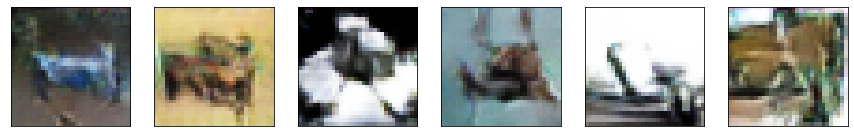

Epoch [18/20], Step[300/782], d_loss: 0.5844, g_loss: 0.9237


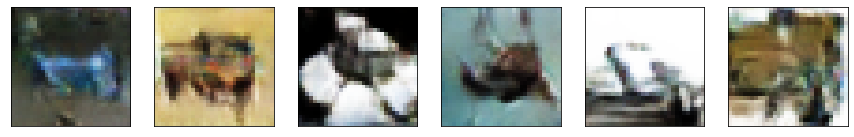

Epoch [18/20], Step[600/782], d_loss: 0.4064, g_loss: 1.1776


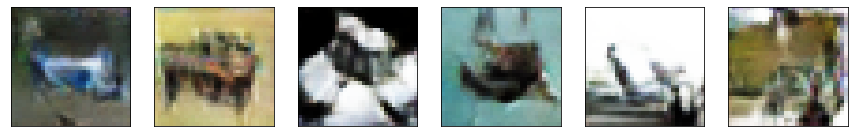

Epoch [19/20], Step[300/782], d_loss: 0.5905, g_loss: 1.1941


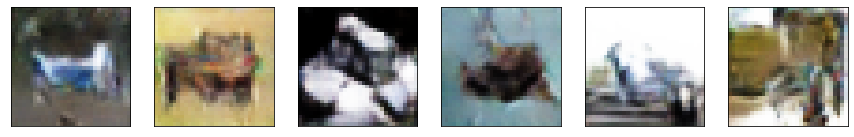

Epoch [19/20], Step[600/782], d_loss: 0.6379, g_loss: 0.9310


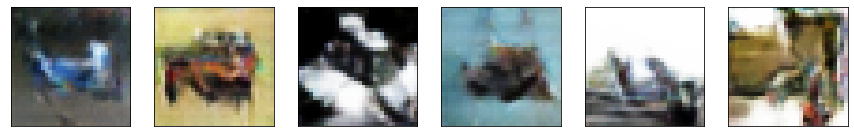

In [21]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999
d_optimizer = optim.Adam(D.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999

fixed_z = torch.randn(6,256).cuda()

# Training
for epoch in range(20):
    for i, (images, _) in enumerate(trainDataLoader):
        G.train()
        D.train()
        
        # Build mini-batch dataset
        batch_size = images.size(0)
        images = images.cuda()
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size).cuda()
        fake_labels = torch.zeros(batch_size).cuda()

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels) # Discriminator가 real image를 1(Real)로 예측하도록 학습
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, 256).cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 fake image를 0(Fake)으로 예측하도록 학습
        fake_score = outputs

        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = torch.randn(batch_size, 256).cuda()
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # Generator에서 생성한 fake image가 Discriminator에서 1(Real)로 예측하도록 학습

        # Backprop + Optimize
        G.zero_grad()
        D.zero_grad()        
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f' 
                  %(epoch, 20, i+1, len(trainDataLoader), d_loss.item(), g_loss.item()))
            print('======================================================================================================')
            
            G.eval()
            fake_images = G(fixed_z)
            fake_images = denorm(fake_images)
            
            images_to_show = fake_images.data.cpu().numpy().transpose((0,2,3,1))
            images_row = images_to_show[:6] 

            plt.figure(figsize=(15,75))
            for a in range(161, 167):    
                plt.subplot(a)
                plt.imshow(images_row[a-161])
                plt.xticks([])
                plt.yticks([])
            plt.show()

## Save checkpoints

In [22]:
torch.save(G.state_dict(),'/content/drive/MyDrive/12-28실습자료/dcgan_generator.pckl')
torch.save(D.state_dict(),'/content/drive/MyDrive/12-28실습자료/dcgan_discriminator.pckl')